SRResNet Trial

https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4

In [1]:
!pip install torch
!pip install pillow
!pip intall numpy
!pip install torchvision
!pip install matplotlib

ERROR: unknown command "intall" - maybe you meant "install"


In [27]:
!pip install utils

In [0]:
from torch import nn
from torch.nn import functional as F
import torch.backends.cudnn as cudnn

from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import Sampler
from torchvision.transforms import (Compose, RandomCrop, ToTensor,
                                    ToPILImage, CenterCrop, Resize)

import torch
import torchvision
import math
import numpy as np
from glob import glob

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import (
    Compose, RandomCrop, ToTensor,
    ToPILImage, CenterCrop, Resize,
    RandomHorizontalFlip, RandomVerticalFlip)
from pathlib import Path
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class ResidualBlock(nn.Module):
    """
    At the core of our very deep generator network G, which
    is illustrated in Figure 4 are B residual blocks with identical
    layout. Inspired by Johnson et al. [33] we employ the block
    layout proposed by Gross and Wilber [24]. Specifically, we
    use two convolutional layers with small 3×3 kernels and 64
    feature maps followed by batch-normalization layers [32]
    and ParametricReLU [28] as the activation function.

    k3n64s1 => 
        kernel_size = 3,
        channels = 64,
        stride = 1
    """
    
    def __init__(self, channels=64, kernel_size=3, stride=1):
        super().__init__()
        padding = 3 // 2
        self.conv1 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=channels)
        self.prelu = nn.PReLU()

        self.conv2 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn2 = nn.BatchNorm2d(num_features=channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        # Element-wise sum
        return residual + x

class SPCNBlock(nn.Module):
    """
    SPCN - sub-pixel convolutional neural network
    We increase the resolution of the input image with two trained
    sub-pixel convolution layers as proposed by Shi et al. [48].

    https://arxiv.org/pdf/1609.05158.pdf

    k3n256s1 => 
        kernel_size = 3,
        channels = 256, (64 * (2 ** 2))
        stride = 1
    """
    def __init__(self, in_channels, 
                upscale_factor=2,
                kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=in_channels * (upscale_factor ** 2),
                            kernel_size=kernel_size,
                            padding=kernel_size // 2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)

        return x

In [0]:
class ConvolutionalBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        layers = list()

        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        output = self.conv_block(input)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_SPCNblocks = int(math.log2(scaling_factor))
        self.SPCNblocks = nn.Sequential(
            *[SPCNBlock(in_channels=n_channels, upscale_factor=2, kernel_size=small_kernel_size) for i
              in range(n_SPCNblocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        output = self.conv_block1(lr_imgs)
        residual = output 
        output = self.residual_blocks(output)  
        output = self.conv_block2(output) 
        output = output + residual 
        output = self.SPCNblocks(output)  
        sr_imgs = self.conv_block3(output)  

        return sr_imgs
        #return output

In [0]:
# Data parameters
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Model parameters
large_kernel_size = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks = 5  # number of residual blocks

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 16  # batch size
workers = 4  # number of workers for loading data in the DataLoader
lr = 0.5  # learning rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# Initialize model or load checkpoint
model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                  n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
# Initialize the optimizer
optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),
                              lr=lr)


# Move to default device
model = model.to(device)
#criterion = nn.MSELoss().to(device)
model

SRResNet(
  (conv_block1): ConvolutionalBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): PReLU(num_parameters=1)
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1

In [8]:
sum(param.numel() for param in model.parameters())

734219

In [0]:
def save_checkpoint(model, filepath):
    
    checkpoint = {'state_dict': model.state_dict()}

    torch.save(checkpoint, filepath)



def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = SRResNet()
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [81]:
filepath = "/content/drive/My Drive/Colab Notebooks/DL/final_project/checkpoint.pth"
os.makedirs("/content/drive/My Drive/Colab Notebooks/DL/final_project/", exist_ok=True)
save_checkpoint(model=model, filepath=filepath)
model = load_checkpoint(filepath)

del model

RuntimeError: ignored

In [0]:
def max_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
    ])

def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


class SRImageDataset(Dataset):
    def __init__(self, dataset_dir, 
                 crop_size=100, 
                 upscale_factor=4):
        super().__init__()
        glob_path = str(Path(dataset_dir) / "*[.jpg, .png]")
        crop_size = max_crop_size(crop_size, upscale_factor)
        
        self.image_filenames = glob(glob_path)[:1000]
        
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [0]:
train_dataset = SRImageDataset(
    dataset_dir="/content/drive/My Drive/Colab Notebooks/DL/final_project/sr/DIV2K_train_HR",
    crop_size=32
)

valid_dataset = SRImageDataset(
    dataset_dir="/content/drive/My Drive/Colab Notebooks/DL/final_project/sr/DIV2K_valid_HR",
    crop_size=500
)

In [45]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=200,
    num_workers=4
)
valid_dataloader = DataLoader(
    dataset=valid_dataset, batch_size=10,
    num_workers=4
)

len(train_dataloader), len(valid_dataloader)

(4, 10)

In [0]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations, div_start=5, div_end=5):
    min_start, min_end = max_lr/div_start, max_lr/div_end
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [0]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat = []
    ys = []
    for lr, hr in valid_dl:
        lr, hr = lr.to(device), hr.to(device)
        batch = hr.shape[0]
        out = model(lr) #.cuda()
        loss = F.mse_loss(out, hr) #.cuda()
        sum_loss += batch*(loss.item())
        total += batch

    return sum_loss/total

def train_model(model, train_dl, valid_dl, optimizer, max_lr=0.05, epochs=100):
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    idx = 0
    best_val_r2 = 0
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    for t in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for lr, hr in train_dl:
            lr, hr = lr.to(device), hr.to(device)
            update_optimizer(optimizer, lrs[idx])
            batch_size = hr.size(0)
            y_hr = model(lr)
            # loss = F.mse_loss(y_hr, hr)
            loss = F.mse_loss(y_hr * 255, hr * 255)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_size
            total += batch_size
            idx +=1
            pbar.update()
        train_loss = total_loss/total
        val_loss = val_metrics(model, valid_dl)

        print("train_loss %.3f val_loss %.3f \n" % 
              (train_loss, val_loss))    
    return 0

In [48]:
train_model(model, train_dataloader,
            valid_dataloader, optimizer, epochs=1)

train_loss 26664.675 val_loss 0.412 



0

In [0]:
PATH = Path("/content/drive/My Drive/Colab Notebooks/DL/final_project/models")

In [37]:
out = model(example.unsqueeze(0).to(device)).to("cpu").squeeze(0)
F.mse_loss(out, hr)

tensor(0.3719, grad_fn=<MseLossBackward>)

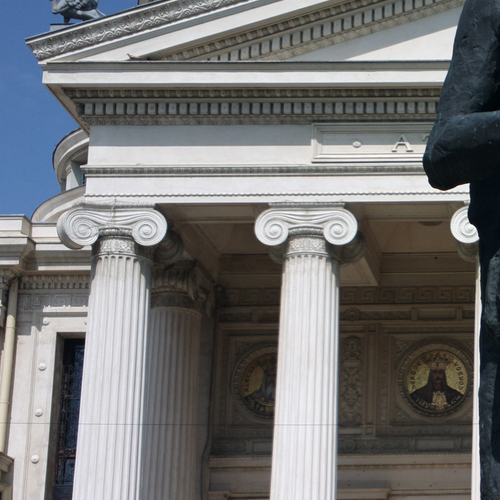

In [38]:
ToPILImage()(hr)